<img src='https://blog.kakaocdn.net/dn/BEXft/btrvvCHYIGL/iL7gQ0RoFU2Bk0RcSDTlIk/img.png'></img>

# 패키지 설치

In [ ]:
pip install finance-datareader

In [ ]:
pip install ta

In [ ]:
import pandas as pd
import os
import FinanceDataReader as fdr
import ta
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import FinanceDataReader as fdr
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore')


#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

# DATA LOAD

In [ ]:
# colab
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
stock_list=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/LSTM/stock/data/stock_list.csv')

In [ ]:
submit=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/LSTM/stock/data/sample_submission.csv')

In [ ]:
stock_list.head()

,종목명,종목코드,상장시장
0,삼성전자,5930,KOSPI
1,SK하이닉스,660,KOSPI
2,NAVER,35420,KOSPI
3,카카오,35720,KOSPI
4,삼성바이오로직스,207940,KOSPI


In [ ]:
stock_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   종목명     370 non-null    object
 1   종목코드    370 non-null    int64 
 2   상장시장    370 non-null    object
dtypes: int64(1), object(2)
memory usage: 8.8+ KB


In [ ]:
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI
...,...,...,...
365,맘스터치,220630,KOSDAQ
366,다날,064260,KOSDAQ
367,제이시스메디칼,287410,KOSDAQ
368,크리스에프앤씨,110790,KOSDAQ


# 샘플 데이터 시작점 체크
* 삼성전자 : 005930
* 네이버 : 035420
* 카카오 : 035720

In [ ]:
dfss = fdr.DataReader('035720') #,'1980-01-01', '2019-12-30'
print(dfss.shape)
dfss.head()

(5513, 6)


,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-11-11,999,999,999,999,12,NaN
1999-11-12,1115,1115,1115,1115,140,0.116116
1999-11-15,1249,1249,1249,1249,405,0.120179
1999-11-16,1396,1396,1396,1396,214,0.117694
1999-11-17,1561,1561,1561,1561,191,0.118195


# 

# Public 예측
* public 점수는 이미 지난 날의 주가를 예측하는 점수이기 때문에 미래 종가 컬럼을 설정하지 않고 당일 종가를 Target 으로 지정하여 예측

## EDA

### 이상치 제거
* 시가 고가 저가가 0인 데이터 존재 -> 금융데이터 핸들링에서는 일반적으로 삭제함.

In [ ]:
dfss.describe()

,Open,High,Low,Close,Volume,Change
count,5513.000000,5513.000000,5513.000000,5513.00000,5.513000e+03,5512.000000
mean,22483.401959,22900.665518,22074.670597,22532.65536,6.009550e+05,0.001437
std,25882.005143,26289.040479,25491.506928,25952.67285,9.657394e+05,0.034701
min,0.000000,0.000000,0.000000,999.00000,0.000000e+00,-0.149424
25%,8743.000000,9021.000000,8485.000000,8744.00000,1.622300e+05,-0.015422
50%,16237.000000,16478.000000,15996.000000,16258.00000,3.421940e+05,0.000000
75%,23643.000000,24085.000000,23202.000000,23584.00000,6.745020e+05,0.014465
max,172000.000000,173000.000000,161000.000000,169500.00000,1.889515e+07,0.149856


In [ ]:
dfss=dfss.drop(dfss[dfss['Open']==0].index,axis=0) #0인 데이터 삭제

## Feature Engineering
<img src="https://blog.kakaocdn.net/dn/cuDi0o/btrvVKHk6AQ/zS6KKc7V6xgMDGFq6vch70/img.png" width="600" height="500"></img>
* '기술적 지표 기반의 주가 움직임 예측 모델 논문'을 참고한 파생변수 목록(7일 예측시 가장 유의미한 변수들)
* 논문은 상승/하락 이진 분류 예측모델에 대한 내용이며, 과거 데이터(2002~2012)이기 때문에 현재와 차이가 있을 수 있으므로 우선 기본적인 지표들 (EMA, RSI, MACD ...)등을 파생변수로 넣어보고 논문 내용을 파생변수로 추가해볼 예정
* 주식 차트 보조지표 개념<br> ref: https://mellowble.tistory.com/226
* 주식 차트 보조지표 코드(ta 라이브러리 사용법)<br> ref : https://junyoru.tistory.com/136
* 기술적 지표 기반의 주가 움직임 예측모델<br>
 ref : https://www.koreascience.or.kr/article/CFKO201924664108348.pdf
* 나스닥, 코스닥, 코스피 지수도 활용 가능

In [ ]:
# 쓸만한 파생변수들
# rsi = ta.momentum.rsi(close)
# macd = ta.trend.macd(close)
# obv = ta.volume.on_balance_volume(close,volume)

# macdsignal = ta.trend.macd_signal(close)
# bol_h = ta.volatility.bollinger_hband(close)
# bol_avg = ta.volatility.bollinger_mavg(close)
# bol_l = ta.volatility.bollinger_lband(close)

### 파생변수 1 : 지수이동평균 (EMA)
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FE8NCh%2Fbtq2iU4B78V%2FoemIOB9SK1rAJ3IjQfA84K%2Fimg.webp" width="800" height="300"></img>
* 선정 이유 : 기존의 rolling을 통한 단순이동평균은 최근 값에 가중치를 두지 않으므로 효과적으로 주가 추세를 반영하지 못한다고 판단
* 개념 : 보다 최근의 값에 가중치를 두면서 이동평균을 계산하는 방법
* ref: https://wendys.tistory.com/178 (SMA, EMA, WMA 설명 및 코드)

In [ ]:
dfss['ema5'] = dfss['Close'].ewm(5).mean()
dfss['ema20'] = dfss['Close'].ewm(20).mean()
dfss['ema100'] = dfss['Close'].ewm(100).mean()

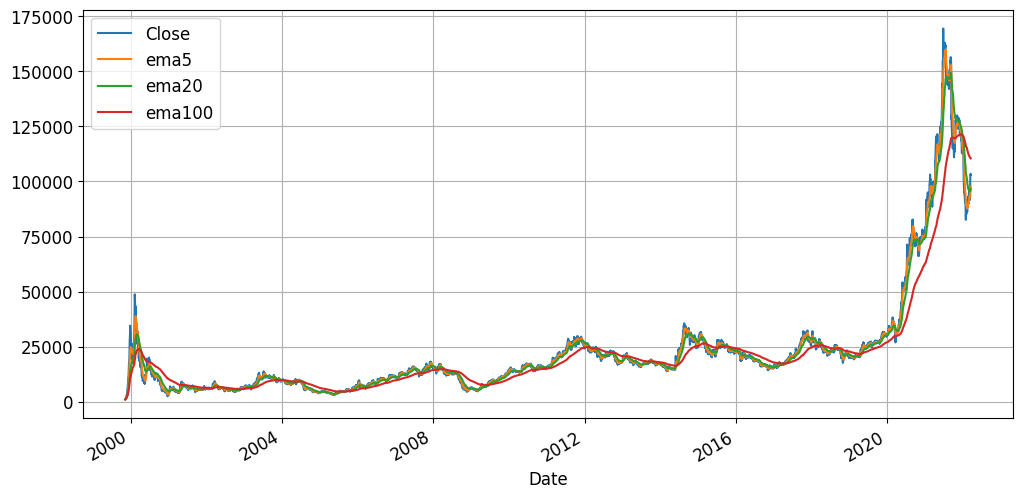

In [ ]:
dfss[['Close','ema5','ema20','ema100']].plot(figsize=(12,6), grid=True)

### 파생변수 2 : Mass Index (MI)
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile3.uf.tistory.com%2Fimage%2F9986A7335CDBCEA3190998" width="800" height="300"></img>
* 선정 이유 : 변동 폭 측정을 통해 패턴화된 추세 전환을 설명할 수 있을 것이라고 판단
* 개념 : 고가와 저가 사이의 변동폭 측정을 통한 추세 전환점 발견 및 확인
* 주가의 변동폭이 커지면 MI는 증가하고 주가의 변동폭이 작아지면 MI는 감소하는 특징을 가지고 있다.

In [ ]:
MI=ta.trend.MassIndex(high= dfss['High'], low= dfss['Low'])
dfss['MI']=MI.mass_index()
dfss.head(10)

,Open,High,Low,Close,Volume,Change,ema5,ema20,ema100,MI
Date,,,,,,,,,,
1999-11-11,999,999,999,999,12,NaN,999.000000,999.000000,999.000000,NaN
1999-11-12,1115,1115,1115,1115,140,0.116116,1062.272727,1058.414634,1057.288557,NaN
1999-11-15,1249,1249,1249,1249,405,0.120179,1136.142857,1125.066614,1121.829280,NaN
1999-11-16,1396,1396,1396,1396,214,0.117694,1219.792846,1197.834634,1191.398361,NaN
1999-11-17,1561,1561,1561,1561,191,0.118195,1314.870135,1277.722298,1266.797022,NaN
1999-11-18,1748,1748,1748,1748,772,0.119795,1423.407335,1365.963176,1349.005723,NaN
1999-11-19,1958,1958,1958,1958,253,0.120137,1546.997998,1463.406696,1438.623321,NaN
1999-11-22,2190,2190,2190,2190,199,0.118488,1686.641648,1570.473205,1535.848704,NaN
1999-11-23,2449,2449,2449,2449,119,0.118265,1844.246190,1688.187495,1641.394856,NaN


In [ ]:
dfss=dfss.dropna()
dfss.head()

,Open,High,Low,Close,Volume,Change,ema5,ema20,ema100,MI
Date,,,,,,,,,,
2000-01-26,21860,22306,19005,19630,394786,-0.085275,22723.713216,19734.032939,15751.453274,39.385518
2000-01-27,18291,18737,17310,17310,247224,-0.118186,21821.358822,19608.688513,15789.654694,35.260175
2000-01-28,16150,19363,15793,19363,515977,0.118602,21411.606295,19596.035943,15875.979489,32.814858
2000-01-31,19006,21683,18381,21683,206802,0.119816,21456.840977,19703.095961,16014.293418,30.992367
2000-02-01,24270,24270,24270,24270,35182,0.119310,21925.721520,19936.516358,16208.232005,29.783729


#### 시각화

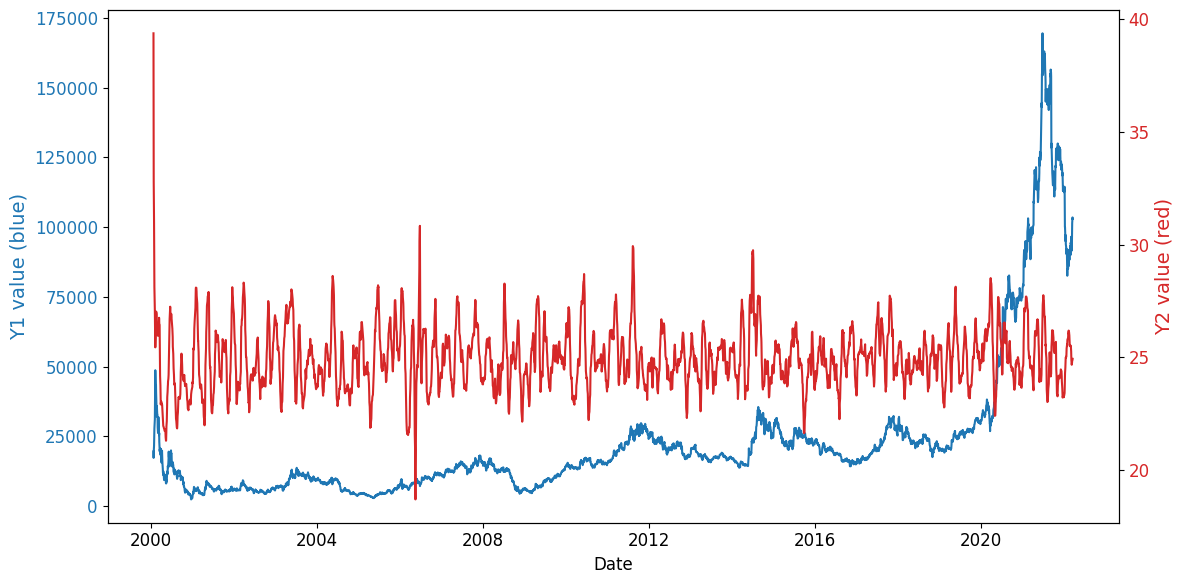

In [ ]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

fig, ax1 = plt.subplots() 
color_1 = 'tab:blue' 
ax1.set_xlabel('Date') 
ax1.set_ylabel('Y1 value (blue)', fontsize=14, color=color_1) 
ax1.plot(dfss.index, dfss.Close, color=color_1) 
ax1.tick_params(axis='y', labelcolor=color_1) 
ax2 = ax1.twinx()
color_2 = 'tab:red' 
ax2.set_ylabel('Y2 value (red)', fontsize=14, color=color_2) 
ax2.plot(dfss.index, dfss.MI, color=color_2) 
ax2.tick_params(axis='y', labelcolor=color_2) 
fig.tight_layout() 
plt.show()


### 파생변수 3 : Relative Strength Index (RSI)
* 개념 : 일정 기간 동안 주가가 전일 가격에 비해 상승한 변화량과 하락한 변화량의 평균값 
* 상승한 변화량이 크면 과매수로, 하락한 변화량이 크면 과매도로 판단

In [ ]:
dfss['RSI'] = ta.momentum.rsi(dfss.Close)
dfss.tail()

,Open,High,Low,Close,Volume,Change,ema5,ema20,ema100,MI,RSI
Date,,,,,,,,,,,
2022-03-08,90000,94000,89600,92100,1774311,0.005459,92896.024606,95431.238655,110848.395833,24.698329,47.825272
2022-03-10,94400,100000,94300,100000,5742398,0.085776,94080.020505,95648.798719,110740.985973,24.778258,61.199078
2022-03-11,100000,102000,98400,101500,3160552,0.015000,95316.683754,95927.427352,110649.491063,24.845594,63.131488
2022-03-14,102500,105000,102000,103500,3656814,0.019704,96680.569795,96288.026049,110578.704022,24.881251,65.592077
2022-03-15,103500,104500,101000,103000,1765832,-0.004831,97733.808163,96607.643856,110503.667349,24.932453,64.434299


### 파생변수 4 : Moving Average Convergence Divergence (MACD)
* 개념 : 이동평균선의 수렴과 확산으로 이동평균선의 변화를 가지고, 주가 상승과 하락을 가늠해보는 지표
* 이 숫자가 양수이면 단기 이동평균선이 중기 이동평균선을 돌파하는 골든크로스가 된다. 이 숫자가 음수이면 반대로 데드크로스

In [ ]:
dfss['MACD'] = ta.trend.macd(dfss.Close)
dfss.tail()

,Open,High,Low,Close,Volume,Change,ema5,ema20,ema100,MI,RSI,MACD
Date,,,,,,,,,,,,
2022-03-08,90000,94000,89600,92100,1774311,0.005459,92896.024606,95431.238655,110848.395833,24.698329,47.825272,-173.586919
2022-03-10,94400,100000,94300,100000,5742398,0.085776,94080.020505,95648.798719,110740.985973,24.778258,61.199078,412.921887
2022-03-11,100000,102000,98400,101500,3160552,0.015000,95316.683754,95927.427352,110649.491063,24.845594,63.131488,987.389791
2022-03-14,102500,105000,102000,103500,3656814,0.019704,96680.569795,96288.026049,110578.704022,24.881251,65.592077,1585.763336
2022-03-15,103500,104500,101000,103000,1765832,-0.004831,97733.808163,96607.643856,110503.667349,24.932453,64.434299,1996.617101


### 파생변수 5 : Moving Average Convergence Divergence Signal (MACD Signal)
* MACD 지표는 MACD Signal과도 비교해 볼 수 있다.
* MACD Signal은 MACD의 9일 이동평균선이다. MACD가 MACD Signal보다 상승한다는 것은 MACD의 값이 9일 평균보다 증가한 것을 의미한다. 즉, 단기 이동평균선이 장기이동평균선보다 커지는 확산 추세에 있는 것을 말한다. 단기 이동평균선의 값이 커지는 것이므로 상승추세에 있는 것을 말한다.

* 반대로 MACD가 MACD Signal보다 작아진다는 것은 MACD 값이 9일 평균보다 감소하는 것을 말한다. 단기 이평선이 장기 이평선보다 작아지는 것으로, 하락하는 추세에 있는 것을 말한다.

In [ ]:
dfss['MACD_signal'] = ta.trend.macd_signal(dfss.Close)
dfss.tail()

,Open,High,Low,Close,Volume,Change,ema5,ema20,ema100,MI,RSI,MACD,MACD_signal
Date,,,,,,,,,,,,,
2022-03-08,90000,94000,89600,92100,1774311,0.005459,92896.024606,95431.238655,110848.395833,24.698329,47.825272,-173.586919,-826.387146
2022-03-10,94400,100000,94300,100000,5742398,0.085776,94080.020505,95648.798719,110740.985973,24.778258,61.199078,412.921887,-578.525339
2022-03-11,100000,102000,98400,101500,3160552,0.015000,95316.683754,95927.427352,110649.491063,24.845594,63.131488,987.389791,-265.342313
2022-03-14,102500,105000,102000,103500,3656814,0.019704,96680.569795,96288.026049,110578.704022,24.881251,65.592077,1585.763336,104.878817
2022-03-15,103500,104500,101000,103000,1765832,-0.004831,97733.808163,96607.643856,110503.667349,24.932453,64.434299,1996.617101,483.226474


### 파생변수 6 : On-balance volume (OBV) <<거래량 분석 지표>>
* 개념 : 거래량은 항상 주가에 선행한다는 것을 전제로 주가의 변동을 분석하는 기법으로 전일에 비해 주가가 상승한 날의 거래량을 OBV에 더하고 하락한 날의 거래량은 OBV에 빼는 방식으로 누적 지수를 만든 것
* 주가가 횡보하거나 하락하는데 OBV가 상승한 경우 세력 매집 중으로 파악되어 추후 상승 가능성이 높음

In [ ]:
dfss['OBV'] = ta.volume.on_balance_volume(dfss.Close,dfss.Volume)
dfss.tail()

,Open,High,Low,Close,Volume,Change,ema5,ema20,ema100,MI,RSI,MACD,MACD_signal,OBV
Date,,,,,,,,,,,,,,
2022-03-08,90000,94000,89600,92100,1774311,0.005459,92896.024606,95431.238655,110848.395833,24.698329,47.825272,-173.586919,-826.387146,303636027
2022-03-10,94400,100000,94300,100000,5742398,0.085776,94080.020505,95648.798719,110740.985973,24.778258,61.199078,412.921887,-578.525339,309378425
2022-03-11,100000,102000,98400,101500,3160552,0.015000,95316.683754,95927.427352,110649.491063,24.845594,63.131488,987.389791,-265.342313,312538977
2022-03-14,102500,105000,102000,103500,3656814,0.019704,96680.569795,96288.026049,110578.704022,24.881251,65.592077,1585.763336,104.878817,316195791
2022-03-15,103500,104500,101000,103000,1765832,-0.004831,97733.808163,96607.643856,110503.667349,24.932453,64.434299,1996.617101,483.226474,314429959


### 파생변수 계산으로 인한 NaN값 제거

In [ ]:
dfss=dfss.dropna()

### 주단위 평균으로 resample
* 이유 1 : 일단위보다 주단위가 차트가 변동성이 없음 -> 학습에 유리
* 이유 2 : 예측 범위가 일주일임
<br>-> NMAE 점수는 오차를 평균으로 한 것이므로 주단위 예측을 해도 상관이 없기 때문에 보다 변동성이 없고 안정적인 주단위 데이터로 학습
* ref: https://rfriend.tistory.com/494

In [ ]:
dfss = dfss.resample("W").mean()
dfss.head()

,Open,High,Low,Close,Volume,Change,ema5,ema20,ema100,MI,RSI,MACD,MACD_signal,OBV
Date,,,,,,,,,,,,,,
2000-03-19,25459.333333,27214.00,23912.666667,24924.333333,678385.666667,-0.036038,28591.715393,29462.001420,24001.543867,26.647176,40.139472,-1241.753981,-310.114395,-1.360392e+06
2000-03-26,20522.000000,21574.60,19219.400000,19897.800000,488358.000000,-0.032449,24663.494009,27952.116324,23806.044138,25.309766,34.051766,-2661.791466,-1467.888285,-1.956065e+06
2000-04-02,19451.600000,21039.60,18362.800000,19684.000000,476450.200000,-0.008156,21789.775836,26186.563557,23492.836633,23.201051,36.632095,-3089.809131,-2527.156062,-1.554571e+06
2000-04-09,16908.000000,17742.75,15895.500000,16658.750000,499329.250000,-0.003196,19382.311387,24489.724681,23088.170120,22.997649,34.316662,-3298.658675,-2968.656425,-2.083080e+06
2000-04-16,17644.500000,18759.75,17171.500000,17573.500000,365188.000000,-0.034159,18546.593833,23287.515573,22762.277366,22.815391,39.862861,-2845.906001,-2988.603664,-2.280201e+06


In [ ]:
dfss.tail()

,Open,High,Low,Close,Volume,Change,ema5,ema20,ema100,MI,RSI,MACD,MACD_signal,OBV
Date,,,,,,,,,,,,,,
2022-02-20,90160.0,91700.0,88580.0,90200.0,2761372.0,-0.000360,88981.927704,97524.801407,113318.571803,25.741226,44.100598,-3629.176746,-5013.831927,2.987998e+08
2022-02-27,91500.0,93660.0,90820.0,92400.0,2473116.6,0.006840,90721.569454,96290.256510,112274.245270,25.517342,49.354657,-1761.817013,-3180.414525,3.016545e+08
2022-03-06,95200.0,96050.0,94200.0,95175.0,1906549.5,0.000887,92644.301631,95826.608443,111468.801824,25.153308,54.625311,-386.069269,-1691.157686,3.035541e+08
2022-03-13,94450.0,97375.0,93475.0,96300.0,3156860.0,0.018375,93836.989598,95651.316328,110818.688165,24.747846,54.725591,277.856966,-664.960500,3.068538e+08
2022-03-20,103000.0,104750.0,101500.0,103250.0,2711323.0,0.007437,97207.188979,96447.834953,110541.185686,24.906852,65.013188,1791.190219,294.052645,3.153129e+08


### 학습에 사용할 데이터 날짜 지정
* 너무 과거 데이터는 코로나 이후 급격한 변동 추세를 반영하지 못한다고 판단하여 2017년 이후 기간으로 설정

In [ ]:
dfss = dfss.loc['2017-01-01':'2020-11-05'].copy()

In [ ]:
dfss = dfss.fillna(method='bfill') #---------- 이전레코드값을 채워라
dfss = dfss.fillna(method='ffill') #---------- 다음레코드값을 채워라

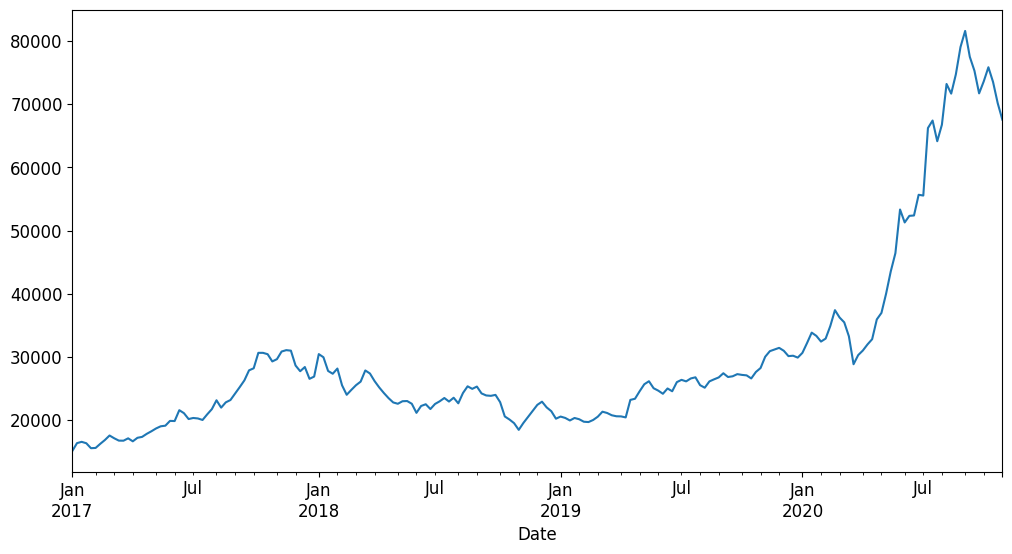

In [ ]:
dfss['Close'].plot()

### MINMAX 스케일링
* 스케일링을 통해 데이터 정규화

In [ ]:
scaler1 = MinMaxScaler()
y_scaler = scaler1.fit_transform(dfss['Close'].values.reshape(-1,1))  # 세로줄 array
print(y_scaler[:5])

[[0.        ]
 [0.01855623]
 [0.02163676]
 [0.01831232]
 [0.00649683]]


In [ ]:
dfss.columns
dfss_col=dfss.columns.tolist()
dfss_col.remove('Close')

In [ ]:
scaler2 = MinMaxScaler()

X_scaler = scaler2.fit_transform(dfss[dfss_col])  # 세로줄 array
print(X_scaler[:5])  #array 2D

dfss = pd.DataFrame(data=X_scaler, columns=dfss_col, index=dfss.index)
dfss['Close'] = y_scaler.reshape(-1,1)
dfss.head()

[[0.         0.         0.         0.00097359 0.579298   0.
  0.         0.01347905 0.14336947 0.31106156 0.24777853 0.21195514
  0.00607986]
 [0.01682563 0.01943619 0.01579137 0.16896462 0.71537942 0.00581648
  0.00099036 0.01134079 0.21974466 0.63726211 0.27955728 0.22074239
  0.01314875]
 [0.02273157 0.02334437 0.0213404  0.05513827 0.50091512 0.01500605
  0.00468629 0.01003476 0.38182315 0.61515167 0.31422044 0.25886522
  0.00916402]
 [0.02122054 0.02050393 0.01874717 0.01764071 0.38412271 0.01738749
  0.00709039 0.00863196 0.44035727 0.49739252 0.31106318 0.27679589
  0.00758553]
 [0.00964672 0.00932433 0.00763529 0.07047256 0.36015619 0.01296272
  0.00686479 0.00679849 0.45286769 0.29662844 0.28087914 0.26543035
  0.        ]]


,Open,High,Low,Volume,Change,ema5,ema20,ema100,MI,RSI,MACD,MACD_signal,OBV,Close
Date,,,,,,,,,,,,,,
2017-01-01,0.000000,0.000000,0.000000,0.000974,0.579298,0.000000,0.000000,0.013479,0.143369,0.311062,0.247779,0.211955,0.006080,0.000000
2017-01-08,0.016826,0.019436,0.015791,0.168965,0.715379,0.005816,0.000990,0.011341,0.219745,0.637262,0.279557,0.220742,0.013149,0.018556
2017-01-15,0.022732,0.023344,0.021340,0.055138,0.500915,0.015006,0.004686,0.010035,0.381823,0.615152,0.314220,0.258865,0.009164,0.021637
2017-01-22,0.021221,0.020504,0.018747,0.017641,0.384123,0.017387,0.007090,0.008632,0.440357,0.497393,0.311063,0.276796,0.007586,0.018312
2017-01-29,0.009647,0.009324,0.007635,0.070473,0.360156,0.012963,0.006865,0.006798,0.452868,0.296628,0.280879,0.265430,0.000000,0.006497


## 샘플 데이터 점수 확인 (LSTM)
* ref : https://teddylee777.github.io/tensorflow/lstm-layer
* 주단위로 resample 했기 때문에 window size는 한달 기준으로 4로 잡음

In [ ]:
window_size = 4
test_size = 5

In [ ]:
train = dfss.iloc[:-test_size ,  : ]
test  = dfss.iloc[-test_size: ,  : ]
train.shape, test.shape

((196, 14), (5, 14))

In [ ]:
test

,Open,High,Low,Volume,Change,ema5,ema20,ema100,MI,RSI,MACD,MACD_signal,OBV,Close
Date,,,,,,,,,,,,,,
2020-10-04,0.874897,0.880410,0.876038,0.203249,0.736736,0.915187,0.991349,0.926258,0.322444,0.383389,0.156026,0.224733,0.948958,0.879876
2020-10-11,0.900134,0.901503,0.912271,0.173711,0.621344,0.926519,0.995938,0.942274,0.313435,0.476829,0.225317,0.189342,0.952737,0.913493
2020-10-18,0.892077,0.879233,0.893622,0.087620,0.343027,0.929154,1.000000,0.964954,0.217281,0.360311,0.244017,0.201403,0.942702,0.878516
2020-10-25,0.832384,0.827727,0.835032,0.151204,0.364343,0.898854,0.991173,0.984903,0.186601,0.211795,0.125460,0.133510,0.928953,0.828047
2020-11-01,0.787164,0.793389,0.790323,0.201928,0.421075,0.857881,0.972600,1.000000,0.299837,0.179076,0.000000,0.000000,0.923186,0.788759


In [ ]:
def my_window_data(df_X, df_y,  window_size=4):
    X_list = []
    y_list = []
    for i in range(len(df_X) - window_size):
        X_list.append(df_X.iloc[i: window_size+i , :])      #[[] ,[] ,[] ,[]]
        y_list.append(df_y.iloc[window_size+i , :])
    return np.array(X_list), np.array(y_list)

In [ ]:
dfss_col=dfss.columns.tolist()
dfss_col.remove('Close')

In [ ]:
X_col = dfss_col #....mon rsi news
y_col = ['Close']
X_train, y_train = my_window_data(train[X_col], train[y_col], 4)
print(X_train.shape, y_train.shape)

X_test, y_test = my_window_data(test[X_col], test[y_col], 4)
print(X_test.shape, y_test.shape)

(192, 4, 13) (192, 1)
(1, 4, 13) (1, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM                 #RNN
# from keras.layers import Dense, Conv2D, MaxPool2D  #CNN
from keras.callbacks import EarlyStopping, ModelCheckpoint

### LSTM 활성화 함수 선정
* 활성화 함수를 바꾸니 성능 크게 향상됨
* 시계열 분석 시 활성화 함수에 따른 성능 비교 논문 참고
* activation='tanh', recurrent_activation='hard_sigmoid'
* Dense는 시계열 분석의 경우 'linear' 함수를 사용하는 것이 성능 향상에 도움
* ref: https://www.koreascience.or.kr/article/JAKO202034352379471.pdf

In [ ]:
lstm = LSTM( units = 1200,
             input_shape=(X_train.shape[1], X_train.shape[2]),  #(4980, 20, 5)  --> (20,5),    
             activation='tanh',
             recurrent_activation='hard_sigmoid',
             dropout=0.0,
             recurrent_dropout=0.0,
             return_sequences=False
      )
model = Sequential()
model.add( lstm )
model.add( Dense(1, activation='linear') )

In [ ]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 1200)              5827200   
                                                                 
 dense_22 (Dense)            (None, 1)                 1201      
                                                                 
Total params: 5,828,401
Trainable params: 5,828,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import os
import shutil

if os.path.exists("./models"):
    shutil.rmtree("./models") 

if not os.path.exists("./models"):
    os.mkdir('./models')  
# if not os.direxists('models') :
#     os.mkdir("models")    

In [ ]:
import tensorflow as tf

In [ ]:
#랜덤시드 설정
tf.random.set_seed(12)
np.random.seed(5)

### 모델학습
* 활성화 함수가 tanh 일 경우 최적화 함수를 adam으로 사용하는게 성능이 좋음 <논문 참고>
* loss는 공모전 평가 점수가 NMAE이기 때문에 MAE로 설정

In [ ]:
with tf.device("/device:GPU:0"):
    model.compile(loss="mae", optimizer='adam', metrics=['mae'])  #, metrics="mse")

    stop = EarlyStopping(patience=10, monitor='val_loss')

    check_point = ModelCheckpoint(filepath='/content/gdrive/MyDrive/Colab Notebooks/stock/models/mymodel_{epoch:02d}_{val_loss:.4f}.h5',
                        monitor='val_loss',          #------------어떤 점수를 기준으로 모니터링할까
                        save_best_only=True,         #------------이전보다 좋아질때만 저장
                        save_weights_only=False      #------------모델+가중치 같이 저장
                    ) 
    res = model.fit(X_train, y_train, 
            callbacks=[stop, check_point],
            epochs = 200,
            batch_size = 16,
            validation_split=0.2
            )

Epoch 1/200
10/10 [==============================] - 4s 170ms/step - loss: 0.0860 - mae: 0.0860 - val_loss: 0.1636 - val_mae: 0.1636
Epoch 2/200
10/10 [==============================] - 1s 152ms/step - loss: 0.0336 - mae: 0.0336 - val_loss: 0.0835 - val_mae: 0.0835
Epoch 3/200
10/10 [==============================] - 2s 199ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0654 - val_mae: 0.0654
Epoch 4/200
10/10 [==============================] - 0s 40ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.1979 - val_mae: 0.1979
Epoch 5/200
10/10 [==============================] - 0s 40ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.1550 - val_mae: 0.1550
Epoch 6/200
10/10 [==============================] - 0s 41ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0824 - val_mae: 0.0824
Epoch 7/200
10/10 [==============================] - 0s 42ms/step - loss: 0.0207 - mae: 0.0207 - val_loss: 0.0736 - val_mae: 0.0736
Epoch 8/200
10/10 [==============================] - 0s 44ms/step - loss:

### loss 그래프 확인

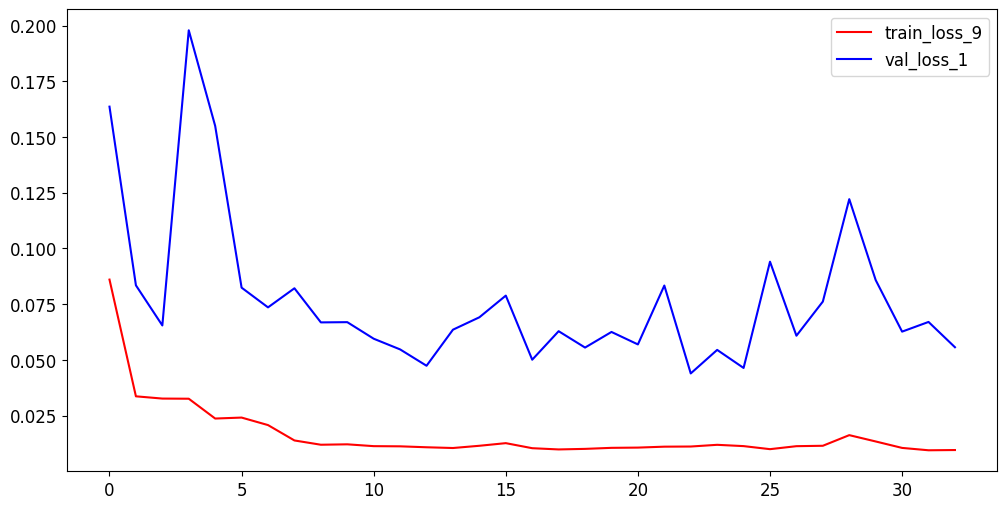

In [ ]:
plt.plot(np.arange(len(res.history['val_loss'])), res.history['loss'], c='red', label='train_loss_9')
plt.plot(np.arange(len(res.history['val_loss'])), res.history['val_loss'], c='blue', label='val_loss_1')
plt.legend()
plt.show()


In [ ]:
pred = model.predict(X_test)
print(pred.shape, y_test.shape)

(1, 1) (1, 1)


In [ ]:
pred_orig   = scaler1.inverse_transform(pred)
y_orig   = scaler1.inverse_transform(y_test)
print(pred_orig[:5])

[[65528.164]]


In [ ]:
print(pred_orig,y_orig)

[[65528.164]] [[67560.8]]


In [ ]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score*100

In [ ]:
NMAE(y_orig,pred_orig)

3.008602529129322

### 샘플 데이터
* 삼성전자 : 005930
* 네이버 : 035420
* 카카오 : 035720


### 파생변수 없이 학습한 결과
* 샘플 테스트 결과 네이버 0.55점 삼성전자 4.8점 카카오 0.14점
* 전체적인 하락장에서 삼성전자만 상승 추세를 보였기 때문에 점수가 낮은 걸로 예상됨 -> 해당 이슈를 상쇄할 수 있는 파생 변수 추가해야할 듯 (뉴스 혹은 차트 보조 지표)


### 파생변수로 EMA만 추가하여 학습한 결과
* 샘플 테스트 결과 네이버 0.62점 삼성전자 0.75점 카카오 1.39점
* 삼성전자 예측력이 크게 향상 되었지만 전반적인 예측력은 떨어진 것으로 보임
* 삼성전자 주가가 주가지수와 반대로가는 성향을 파생 변수로 잡았지만 전체적인 예측력에도 영향이 간 듯 -> 유의미한 파생변수로 판단


### 파생변수 EMA + MI 학습한 결과
* 샘플 테스트 결과 네이버 4.74점 삼성전자 1.94점 카카오 7.17점
* 전체적인 예측력이 크게 떨어짐 MI가 EMA와 같이 들어가서 그런건지 확인을 해볼 필요가 있을 듯 

### 파생변수 MI만 학습한 결과
* 샘플 테스트 결과 네이버 2.86점 삼성전자 2.54점 카카오 6.32점
* 삼성전자는 파생변수 없이 학습한 것 보다는 나았는데 카카오/네이버 예측력이 크게 떨어짐
* 삼성전자과 달리 IT기업주가 2020년 4월 경 급등함 차트의 꾸준한 패턴과 달리 변동성이 있었기 때문에 IT기업주가 예측력이 떨어질 수도 있을듯
* 예측력을 크게 저하시키기 때문에 제거해야할 파생변수로 판단

### 파생변수 EMA + RSI + MACD + OBV 학습한 결과
* 샘플 테스트 결과 네이버 2.6점 삼성전자 6.93점 카카오 7.5점
* 파생변수를 한 번에 많이 추가하니까 예측력이 많이 떨어짐
* MACD 시그널도 파생변수로 추가 (보통 같이 씀)
* 유의미한 파생변수만 골라내는 작업이 필요할 듯
* 샘플 데이터도 네이버/카카오 중 하나만 선택하고 다른 산업군으로 테스트 해봐야할 듯

### 파생변수 EMA + MI + RSI + MACD + MACD Signal + OBV 학습한 결과
* 샘플 테스트 결과 네이버 4.4점 삼성전자 5.3점 카카오 3.0점
* 일단 만든 파생변수를 전부 집어넣고 테스트 해봄
* 성능이 매우 떨어져서 파생변수를 의미없는 성능을 감소시키는 feature를 구별하는 테스트를 해봐야 할 듯 

### 파생변수 EMA + RSI + MACD + MACD Signal + OBV 학습한 결과
* 샘플 테스트 결과 네이버 6.5점 삼성전자 5.77점 카카오 6.95점
* MI가 파생변수의 수가 적을 때는 의미없는 feature로 보였지만 여러 파생변수와 조합하니 성능이 소폭 향상됨
* 파생 변수의 조합별로 성능이 다르다 -> 최대한 많은 피쳐를 추가하고 삭제하면서 최적의 성능을 구해야 할 듯

### 생각해볼 것들
* 학습 데이터 기간 설정을 해가면서 최적의 기간 도출해보기..
* 자연어 처리를 통한 뉴스 기사 파생 변수
* 주가 차트를 이미지화하여 CNN을 통한 학습

# Private 예측
* Private 점수는 미래 주가를 예측하기 때문에 미래 주가컬럼을 shift 함수를 통해 따로 추가하여 Target으로 설정 

# Submit을 위한 함수 생성